In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_curve

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv').squeeze()


In [15]:
def evaluate_model(model_name, y_true, y_pred, y_proba, save_prefix=None):
    print(f"\n==== {model_name} ====")
    print("Classification Report:\n", classification_report(y_true, y_pred))

    auc = roc_auc_score(y_true, y_proba)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    pr, rc, _ = precision_recall_curve(y_true, y_proba)

    # ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{model_name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    if save_prefix:
        plt.savefig(f"../results/plots/{save_prefix}_roc.png")
    plt.grid()
    plt.show()

    # PR Curve
    plt.figure()
    plt.plot(rc, pr, label=model_name)
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if save_prefix:
        plt.savefig(f"../results/plots/{save_prefix}_prc.png")
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    if save_prefix:
        plt.savefig(f"../results/plots/{save_prefix}_confusion_matrix.png")
    plt.show()

    return auc


In [2]:
param_dist = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}


In [3]:
rf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',  # use 'f1' or 'balanced_accuracy' for other targets
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best AUC-ROC Score:", random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'n_estimators': 300, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced'}
Best AUC-ROC Score: 0.7864361380604332


In [5]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# Load data
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv').squeeze()


In [6]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

    return np.mean(scores)


In [7]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=900)  # 15 minutes max

print("Best AUC-ROC Score:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-05-03 21:24:00,919] A new study created in memory with name: no-name-8d15638a-d9e3-4d81-8b8e-877a985391f5
[I 2025-05-03 21:24:03,837] Trial 0 finished with value: 0.7852292815352262 and parameters: {'n_estimators': 303, 'max_depth': 8, 'learning_rate': 0.04003142260381522, 'subsample': 0.8512848875710295, 'colsample_bytree': 0.6312475207584282, 'gamma': 0.6724743546019241, 'reg_alpha': 0.5610759971176559, 'reg_lambda': 0.1431008732042922}. Best is trial 0 with value: 0.7852292815352262.
[I 2025-05-03 21:24:05,036] Trial 1 finished with value: 0.7720997372800239 and parameters: {'n_estimators': 119, 'max_depth': 8, 'learning_rate': 0.2758796802189437, 'subsample': 0.7831007668538159, 'colsample_bytree': 0.7558729677963519, 'gamma': 4.904438651163593, 'reg_alpha': 0.9643956420117908, 'reg_lambda': 0.2704005448624408}. Best is trial 0 with value: 0.7852292815352262.
[I 2025-05-03 21:24:09,430] Trial 2 finished with value: 0.752104504926291 and parameters: {'n_estimators': 480, 'ma

Best AUC-ROC Score: 0.7976402944253614
Best Params: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.16468050184016525, 'subsample': 0.941910362371582, 'colsample_bytree': 0.831441135320093, 'gamma': 3.4324499559061663, 'reg_alpha': 0.461553090157237, 'reg_lambda': 0.5987432745882633}


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:27:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



==== XGBoost (Tuned) ====
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.88      7985
           1       0.34      0.65      0.44      1058

    accuracy                           0.81      9043
   macro avg       0.64      0.74      0.66      9043
weighted avg       0.88      0.81      0.83      9043



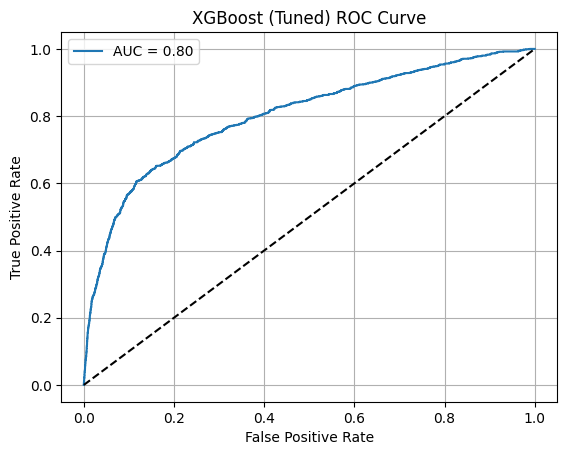

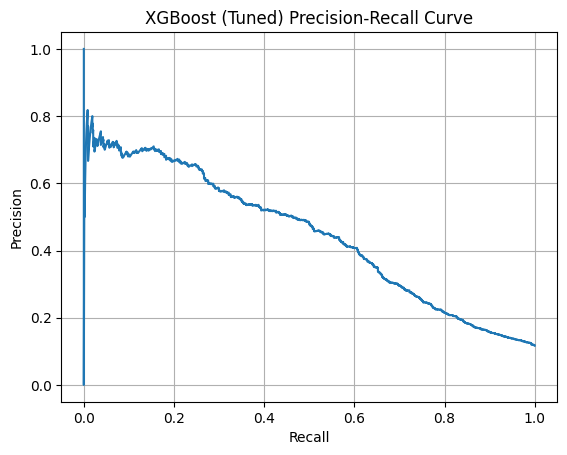

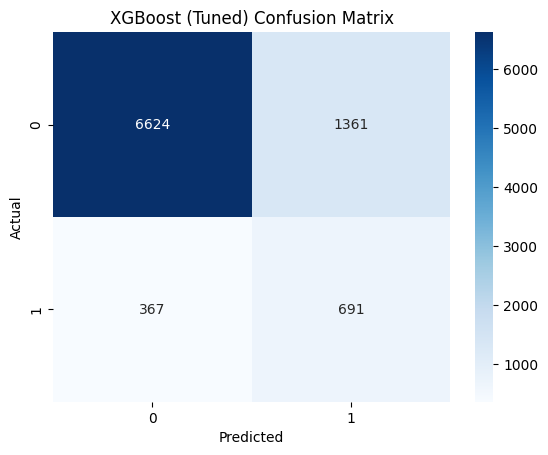

Tuned XGBoost AUC: 0.8022


In [16]:
# Retrain on full training set with best params
best_params = study.best_params
best_params.update({
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42
})

best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

# Evaluate on test set
X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv').squeeze()

y_pred_xgb_tuned = best_xgb_model.predict(X_test)
y_proba_xgb_tuned = best_xgb_model.predict_proba(X_test)[:, 1]

auc_xgb_tuned = evaluate_model("XGBoost (Tuned)", y_test, y_pred_xgb_tuned, y_proba_xgb_tuned, save_prefix="xgb_tuned")
print(f"Tuned XGBoost AUC: {auc_xgb_tuned:.4f}")


In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Load data
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv').squeeze()
X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv').squeeze()

# Standardize inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
param_dist = {
    'hidden_layer_sizes': [(128,), (64, 32), (100, 50, 25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.05],
    'solver': ['adam'],
    'max_iter': [300],
    'early_stopping': [True]
}


In [19]:
mlp = MLPClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

print("Best MLP Params:", random_search.best_params_)
print("Best AUC-ROC Score:", random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best MLP Params: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (128,), 'early_stopping': True, 'alpha': 0.01, 'activation': 'relu'}
Best AUC-ROC Score: 0.7769452379312661



==== MLP Neural Network (Tuned) ====
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.63      0.24      0.35      1058

    accuracy                           0.89      9043
   macro avg       0.77      0.61      0.65      9043
weighted avg       0.87      0.89      0.87      9043



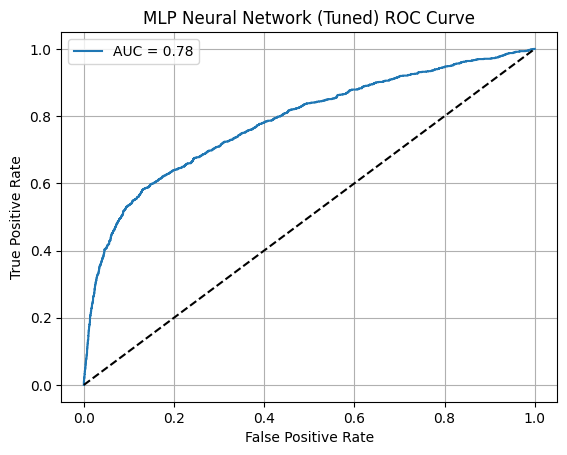

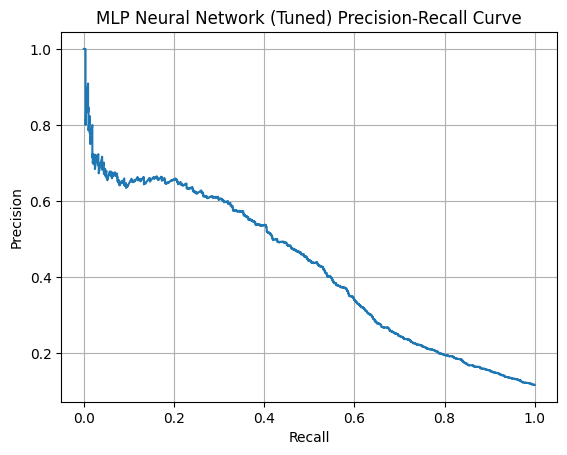

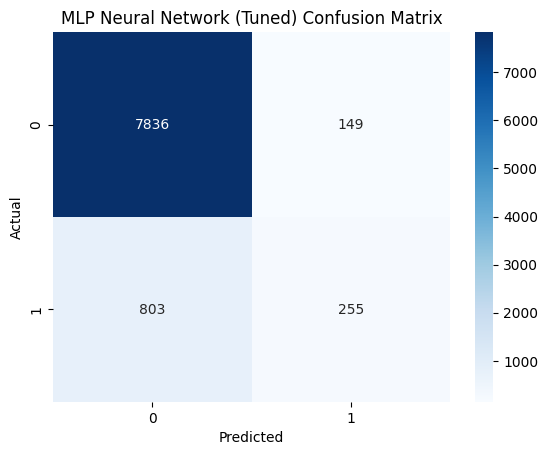

Tuned MLP AUC: 0.7827


In [20]:
best_mlp_model = random_search.best_estimator_

y_pred_mlp_tuned = best_mlp_model.predict(X_test_scaled)
y_proba_mlp_tuned = best_mlp_model.predict_proba(X_test_scaled)[:, 1]

auc_mlp_tuned = evaluate_model("MLP Neural Network (Tuned)", y_test, y_pred_mlp_tuned, y_proba_mlp_tuned, save_prefix="mlp_tuned")
print(f"Tuned MLP AUC: {auc_mlp_tuned:.4f}")
